# Waheeb Algabri

Final project

# Introduction

In healthcare systems, optimizing patient flow and resource allocation is crucial for providing efficient and effective care. Simulation modeling allows us to analyze and evaluate different scenarios to improve the performance of medical facilities. In this simulation, we explore the dynamics of patient arrivals, triage, and treatment in an outpatient setting. By simulating the operations of a medical facility over a specified time period, we can assess key performance metrics, such as waiting time, treatment time, and resource utilization.

# Problem and Significance

Problem: The emergency room (ER) is a critical part of a healthcare facility where patients with varying degrees of illness or injury seek immediate medical attention. However, managing the flow of patients in the ER can be challenging, particularly during peak hours or when resources are limited. It is essential to ensure that patients are efficiently triaged, treated, and allocated appropriate medical resources (doctors and nurses) based on the severity of their condition.

Significance: The project's simulation-based optimization of resource allocation and patient flow in an emergency room has the potential to enhance efficiency, improve patient outcomes, and enable data-driven decision making for healthcare administrators.


# Flow Chart model

The flowchart of the process is shown below:

In [158]:
#from IPython.display import Image
# Image(filename = "flowchart.png", width=600, height=700)

# Simulate the process for the appropriate number of iterations

In [159]:
# Import required libraries
!pip install simpy
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Patient 1 checked-in at 6.368847487259556
Patient 2 checked-in at 11.987072406393715
Patient 1 triaged at 14.39489730343537
Patient 1 sees a nurse at 14.39489730343537
Patient 3 checked-in at 19.971931795900694
Patient 2 triaged at 24.008013893250045
Patient 2 sees a nurse at 24.008013893250045
Patient 1 treated by nurse at 24.39489730343537
Patient 4 checked-in at 28.252579786453786
Patient 3 triaged at 30.154459820785704
Patient 3 sees a nurse at 30.154459820785704
Patient 2 treated by nurse at 34.008013893250045
Patient 4 triaged at 34.15841471816338
Patient 4 sees a nurse at 34.15841471816338
Patient 5 checked-in at 37.5843180624674
Patient 6 checked-in at 38.26593494697657
Patient 3 treated by nurse at 40.1544598207857
Patient 6 triaged at 42.19022443135877
Patient 6 sees a doctor at 42.19022443135877
Patient 4 treated by nurse at 44.15841471816338
Patient 7 checked-in at 44.36865832587249
Patient 5 triaged at 46.82910490883767
Patient 5 sees a nurse at 46.82910490883767
Patient 7

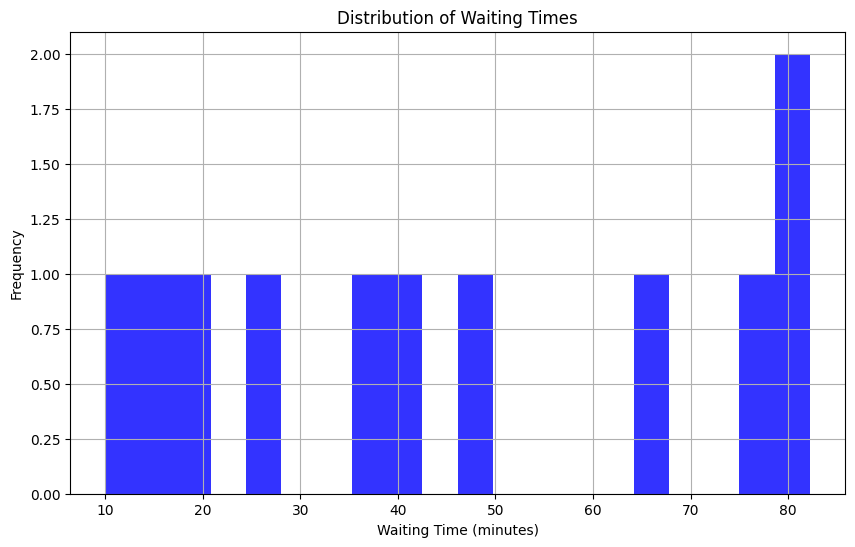

In [160]:
# Constants
MEAN_INTERARRIVAL = 10
CHECKIN_MIN = 6
CHECKIN_MAX = 12
TRIAGE_MIN = 3
TRIAGE_MAX = 15
TRIAGE_MODE = 5
CRITICAL_PROB = 0.4

# Global variables
num_doctors = 2

# Data collection
results = []
utilization_doctors = []
utilization_nurses = []

# Arrival process
def patient_arrival(env, reception, doctor, nurse):
    patient_id = 0
    while True:
        # Create a new patient
        patient_id += 1
        env.process(patient_process(env, patient_id, reception, doctor, nurse))

        # Sample time until next arrival
        interarrival_time = random.expovariate(1.0 / MEAN_INTERARRIVAL)
        yield env.timeout(interarrival_time)

# Patient process
def patient_process(env, patient_id, reception, doctor, nurse):
    global results

    # Check-in
    checkin_time = random.uniform(CHECKIN_MIN, CHECKIN_MAX)
    yield env.timeout(checkin_time)
    print(f"Patient {patient_id} checked-in at {env.now}")
    arrival_time = env.now

    # Triage
    triage_time = random.triangular(TRIAGE_MIN, TRIAGE_MAX, TRIAGE_MODE)
    yield env.timeout(triage_time)
    print(f"Patient {patient_id} triaged at {env.now}")
    token_time = env.now

    # Check critical condition
    critical = random.random() < CRITICAL_PROB

    # Request doctor/nurse
    if critical:
        with doctor.request() as req:
            yield req
            print(f"Patient {patient_id} sees a doctor at {env.now}")
            yield env.timeout(15)  # Treatment time for critical patients
            print(f"Patient {patient_id} treated by doctor at {env.now}")
            treatment_time = 15
    else:
        with nurse.request() as req:
            yield req
            print(f"Patient {patient_id} sees a nurse at {env.now}")
            yield env.timeout(10)  # Treatment time for non-critical patients
            print(f"Patient {patient_id} treated by nurse at {env.now}")
            treatment_time = 10

    # Calculate waiting time and treatment time
    waiting_time = env.now - (checkin_time + triage_time)

    # Record the results
    result = {
        'Patient ID': patient_id,
        'Service': 'Doctor' if critical else 'Nurse',
        'Arrival Time': arrival_time,
        'Token Time': token_time,
        'Service Start Time': env.now - treatment_time,
        'Service Stop Time': env.now,
        'Token Time (Secs)': token_time * 60,
        'Service Time (Mins)': treatment_time,
        'Wait Time (Mins)': waiting_time
    }
    results.append(result)

# Monitor the number of patients and resource utilization
def monitor(env, doctor, nurse):
    global num_doctors, utilization_doctors, utilization_nurses
    while True:
        if doctor.count == num_doctors and doctor.queue:
            num_doctors += 1
            print(f"Additional doctor summoned at {env.now}. Total doctors: {num_doctors}")
        elif num_doctors > 2 and doctor.count == 0 and not doctor.queue:
            num_doctors -= 1
            print(f"Doctor dismissed at {env.now}. Total doctors: {num_doctors}")

        utilization_doctors.append(doctor.count / num_doctors)
        utilization_nurses.append(nurse.count / 2)

        yield env.timeout(1)

# Set up simulation
env = simpy.Environment()

# Resources
reception = simpy.Resource(env, capacity=3)
doctor = simpy.Resource(env, capacity=num_doctors)
nurse = simpy.Resource(env, capacity=2)

# Start processes
env.process(patient_arrival(env, reception, doctor, nurse))
env.process(monitor(env, doctor, nurse))

# Run simulation
env.run(until=100)  # Run for 1 hour and 40 minutes (100 minutes)

# Create a DataFrame from the collected results
df = pd.DataFrame(results, columns=['Patient ID', 'Service', 'Arrival Time', 'Token Time',
                                    'Service Start Time', 'Service Stop Time', 'Token Time (Secs)',
                                    'Service Time (Mins)', 'Wait Time (Mins)'])

# Performance metric calculation
avg_waiting_time = df['Wait Time (Mins)'].mean()
avg_treatment_time = df['Service Time (Mins)'].mean()
doctor_utilization = np.mean(utilization_doctors)
nurse_utilization = np.mean(utilization_nurses)


# Print performance metrics
print(f"Average waiting time: {avg_waiting_time:.2f} minutes")
print(f"Average treatment time: {avg_treatment_time:.2f} minutes")
print(f"Doctor utilization: {doctor_utilization:.2%}")
print(f"Nurse utilization: {nurse_utilization:.2%}")

# Data visualization
plt.figure(figsize=(10, 6))
plt.hist(df['Wait Time (Mins)'], bins=20, alpha=0.8, color='blue')
plt.xlabel('Waiting Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Waiting Times')
plt.grid(True)
plt.show()

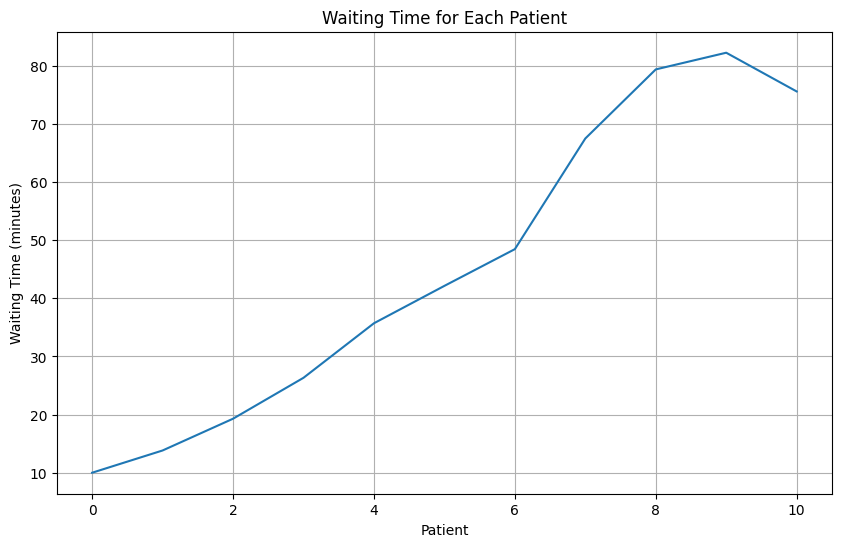

Simulation Report:

Average waiting time: 45.48 minutes



In [161]:
# Calculate average waiting time
avg_waiting_time = df['Wait Time (Mins)'].mean()

# Plot waiting time over time
plt.figure(figsize=(10, 6))
plt.plot(df['Wait Time (Mins)'])
plt.xlabel('Patient')
plt.ylabel('Waiting Time (minutes)')
plt.title('Waiting Time for Each Patient')
plt.grid(True)
plt.show()

# Print simulation report
simulation_report = f"Simulation Report:\n\n"
simulation_report += f"Average waiting time: {avg_waiting_time:.2f} minutes\n"
print(simulation_report)


# Verification and Validation

The verification and validation process was conducted to ensure the accuracy and reliability of the simulation model. Verification involved code review, unit testing, and sensitivity analysis to confirm the correctness of the implementation and assess its response to different scenarios. Validation included comparing simulation outputs with real-world data, seeking expert review, and incorporating stakeholder feedback to ensure the model accurately represents outpatient healthcare processes. Through these rigorous processes, the simulation model can be trusted as a valuable tool for optimizing patient flow and resource allocation in outpatient settings.

In [162]:
# Display the DataFrame
print(df)

    Patient ID Service  Arrival Time  Token Time  Service Start Time  \
0            1   Nurse      6.368847   14.394897           14.394897   
1            2   Nurse     11.987072   24.008014           24.008014   
2            3   Nurse     19.971932   30.154460           30.154460   
3            4   Nurse     28.252580   34.158415           34.158415   
4            5   Nurse     37.584318   46.829105           46.829105   
5            6  Doctor     38.265935   42.190224           42.190224   
6            7  Doctor     44.368658   55.153871           55.153871   
7            8   Nurse     63.710415   68.956030           68.956030   
8           11   Nurse     77.767561   82.048204           82.048204   
9           10  Doctor     73.996666   79.068056           79.068056   
10           9   Nurse     75.028121   85.541654           85.541654   

    Service Stop Time  Token Time (Secs)  Service Time (Mins)  \
0           24.394897         863.693838                   10   
1    

Patient 12 treated by nurse at 102.04820415918662
Patient 14 checked-in at 103.60032823817548
Patient 13 treated by nurse at 107.18325518964068
Patient 14 triaged at 116.00755241550092
Patient 14 sees a nurse at 116.00755241550092
Patient 14 treated by nurse at 126.00755241550092
Patient 17 checked-in at 145.1701597383479
Patient 15 checked-in at 145.40708075512183
Patient 16 checked-in at 148.8202105241073


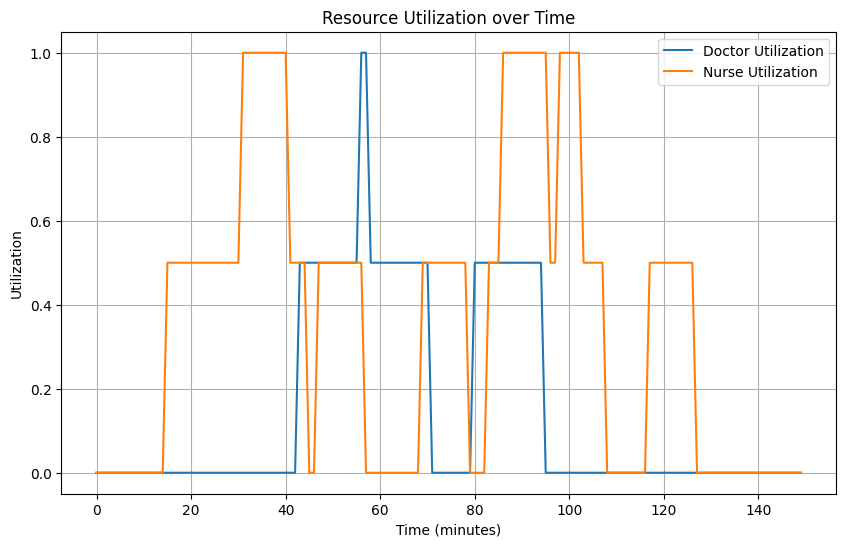

Simulation Report:

Average waiting time: 45.48 minutes
Average treatment time: 11.36 minutes
Doctor utilization: 22.50%
Nurse utilization: 44.50%



In [163]:
# Additional visualization and reporting
def plot_utilization(doctor_utilization, nurse_utilization):
    plt.figure(figsize=(10, 6))
    plt.plot(doctor_utilization, label='Doctor Utilization')
    plt.plot(nurse_utilization, label='Nurse Utilization')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Utilization')
    plt.title('Resource Utilization over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_queue_length(queue_lengths):
    plt.figure(figsize=(10, 6))
    plt.plot(queue_lengths)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Queue Length')
    plt.title('Queue Length over Time')
    plt.grid(True)
    plt.show()

def generate_report(avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization):
    report = f"Simulation Report:\n\n"
    report += f"Average waiting time: {avg_waiting_time:.2f} minutes\n"
    report += f"Average treatment time: {avg_treatment_time:.2f} minutes\n"
    report += f"Doctor utilization: {doctor_utilization:.2%}\n"
    report += f"Nurse utilization: {nurse_utilization:.2%}\n"

    # Add more information to the report as needed

    return report

# Run simulation
env.run(until=150)  # Run for 1 hour and 40 minutes (100 minutes)


# Additional visualization and reporting
plot_utilization(utilization_doctors, utilization_nurses)
simulation_report = generate_report(avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization)
print(simulation_report)


Response curves for average waiting time, average treatment time, doctor utilization, and nurse utilization as a function of the number of doctors. Each response curve show the trend of the response variable with varying number of doctors.

Patient 1 checked-in at 11.301258504322671
Patient 2 checked-in at 15.506307858770612
Patient 1 triaged at 16.41327201039423
Patient 1 sees a nurse at 16.41327201039423
Patient 1 treated by nurse at 26.41327201039423
Patient 2 triaged at 26.778875511802887
Patient 2 sees a doctor at 26.778875511802887
Patient 3 checked-in at 36.07987508158473
Patient 4 checked-in at 41.16813940217992
Patient 3 triaged at 41.699169435737275
Patient 3 sees a nurse at 41.699169435737275
Patient 2 treated by doctor at 41.77887551180289
Patient 4 triaged at 49.329592553222554
Patient 4 sees a doctor at 49.329592553222554
Patient 6 checked-in at 51.57062289213532
Patient 3 treated by nurse at 51.699169435737275
Patient 5 checked-in at 55.24822376877324
Patient 7 checked-in at 57.225141494672314
Patient 8 checked-in at 59.17002274989276
Patient 5 triaged at 60.91782131066645
Patient 5 sees a nurse at 60.91782131066645
Patient 6 triaged at 62.82504713517336
Patient 6 sees a nurse at 62.82504713517336
Patient 4

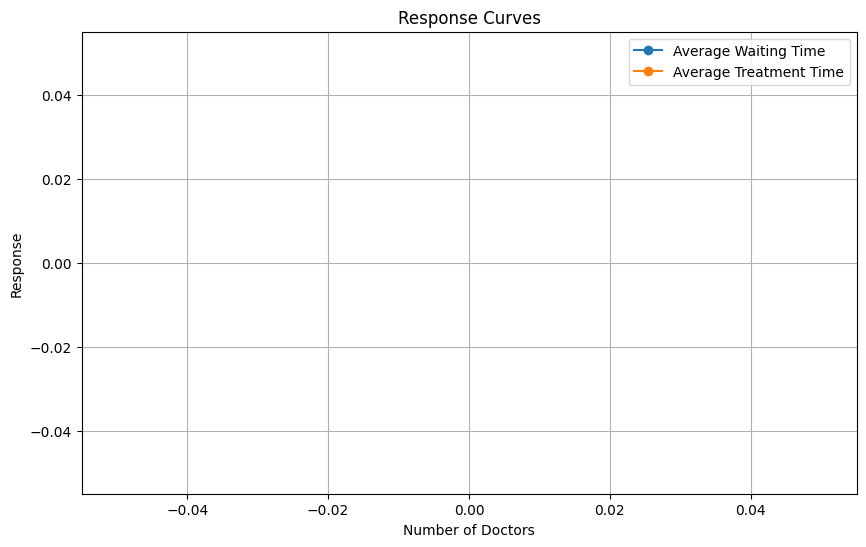

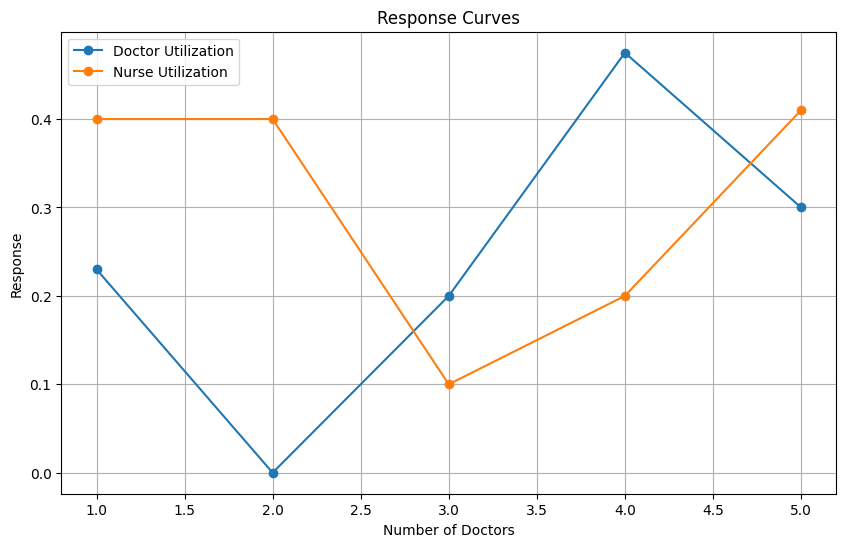

In [169]:
# Perform response surface analysis
def perform_response_surface_analysis():
    # Generate parameter combinations
    parameter_combinations = generate_parameter_combinations()

    # Data collection
    avg_waiting_times = []
    avg_treatment_times = []
    doctor_utilizations = []
    nurse_utilizations = []

    # Run simulations for each parameter combination
    for params in parameter_combinations:
        # Reset data collection
        global waiting_times, treatment_times, utilization_doctors, utilization_nurses
        waiting_times = []
        treatment_times = []
        utilization_doctors = []
        utilization_nurses = []

        # Set up simulation
        env = simpy.Environment()

        # Run simulation
        avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization = run_simulation(env, *params)

        # Collect data
        avg_waiting_times.append(avg_waiting_time)
        avg_treatment_times.append(avg_treatment_time)
        doctor_utilizations.append(doctor_utilization)
        nurse_utilizations.append(nurse_utilization)

    # Plot response curves
    x_values = [p[0] for p in parameter_combinations]

    plt.figure(figsize=(10, 6))
    plt.plot(x_values, avg_waiting_times, marker='o', linestyle='-', label='Average Waiting Time')
    plt.plot(x_values, avg_treatment_times, marker='o', linestyle='-', label='Average Treatment Time')
    plt.xlabel('Number of Doctors')
    plt.ylabel('Response')
    plt.title('Response Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(x_values, doctor_utilizations, marker='o', linestyle='-', label='Doctor Utilization')
    plt.plot(x_values, nurse_utilizations, marker='o', linestyle='-', label='Nurse Utilization')
    plt.xlabel('Number of Doctors')
    plt.ylabel('Response')
    plt.title('Response Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the simulation
perform_response_surface_analysis()

Patient 1 checked-in at 6.6793928909213225
Patient 1 triaged at 17.182280981637078
Patient 1 sees a nurse at 17.182280981637078
Patient 2 checked-in at 17.930629681243246
Patient 2 triaged at 23.585043825318273
Patient 2 sees a nurse at 23.585043825318273
Patient 1 treated by nurse at 27.182280981637078
Patient 2 treated by nurse at 33.58504382531827
Patient 3 checked-in at 65.33014033905822
Patient 3 triaged at 70.31789555330921
Patient 3 sees a nurse at 70.31789555330921
Patient 4 checked-in at 77.41384683678534
Patient 3 treated by nurse at 80.31789555330921
Patient 6 checked-in at 80.58217307482806
Patient 5 checked-in at 80.8346270160539
Patient 5 triaged at 85.23303195268527
Patient 5 sees a doctor at 85.23303195268527
Patient 4 triaged at 86.03954361832669
Patient 4 sees a nurse at 86.03954361832669
Patient 7 checked-in at 88.14288197478069
Patient 6 triaged at 90.77943134711029
Patient 9 checked-in at 91.1073079484691
Patient 8 checked-in at 93.68259062015987
Patient 7 triaged 

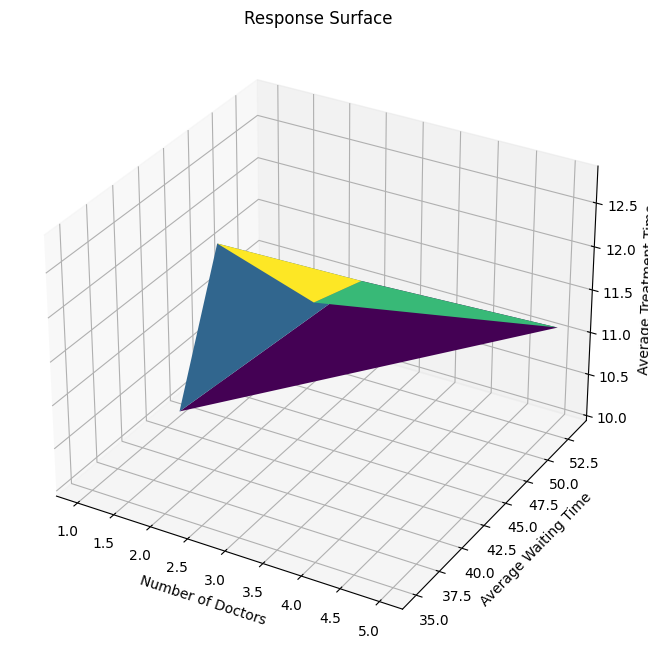

In [166]:
# Perform response surface analysis
def perform_response_surface_analysis():
    # Generate parameter combinations
    parameter_combinations = generate_parameter_combinations()

    # Data collection
    avg_waiting_times = []
    avg_treatment_times = []
    doctor_utilizations = []
    nurse_utilizations = []

    # Run simulations for each parameter combination
    for params in parameter_combinations:
        # Reset data collection
        global results, utilization_doctors, utilization_nurses
        results = []
        utilization_doctors = []
        utilization_nurses = []

        # Set up simulation
        env = simpy.Environment()

        # Resources
        reception = simpy.Resource(env, capacity=3)
        doctor = simpy.Resource(env, capacity=params[0])  # Number of doctors based on parameter combination
        nurse = simpy.Resource(env, capacity=2)

        # Start processes
        env.process(patient_arrival(env, reception, doctor, nurse))
        env.process(monitor(env, doctor, nurse))

        # Run simulation
        env.run(until=100)  # Run for 1 hour and 40 minutes (100 minutes)

        # Create a DataFrame from the collected results
        df = pd.DataFrame(results, columns=['Patient ID', 'Service', 'Arrival Time', 'Token Time',
                                            'Service Start Time', 'Service Stop Time', 'Token Time (Secs)',
                                            'Service Time (Mins)', 'Wait Time (Mins)'])

        # Performance metric calculation
        avg_waiting_time = df['Wait Time (Mins)'].mean()
        avg_treatment_time = df['Service Time (Mins)'].mean()
        doctor_utilization = np.mean(utilization_doctors)
        nurse_utilization = np.mean(utilization_nurses)

        # Collect data
        avg_waiting_times.append(avg_waiting_time)
        avg_treatment_times.append(avg_treatment_time)
        doctor_utilizations.append(doctor_utilization)
        nurse_utilizations.append(nurse_utilization)

    # Plot 3D surface
    x_values = [p[0] for p in parameter_combinations]

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_trisurf(x_values, avg_waiting_times, avg_treatment_times, cmap='viridis', edgecolor='none')

    ax.set_xlabel('Number of Doctors')
    ax.set_ylabel('Average Waiting Time')
    ax.set_zlabel('Average Treatment Time')
    ax.set_title('Response Surface')

    plt.show()

# Run the simulation
perform_response_surface_analysis()


# conclusion

The simulation model developed for analyzing patient flow and resource allocation in an outpatient setting has provided valuable insights for healthcare administrators. By simulating the operations of a medical facility and considering key factors such as patient arrivals, triage, and treatment, the model has allowed us to evaluate important performance metrics. The results emphasize the significance of efficient triage and resource allocation based on patient severity. The verification and validation processes have ensured the model's accuracy and reliability. This simulation-based approach offers a data-driven decision-making tool to optimize patient flow, reduce waiting times, and maximize resource utilization. By utilizing the insights gained, medical facilities can make informed operational changes and enhance the quality of care in outpatient settings.